# Distribution analysis of clusters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
# from vae import VAE
from dataloader import UTKFaceDataset
import seaborn as sns
import pandas as pd
from ae import AutoEncoderNet
from torchvision.utils import make_grid
from sklearn import metrics
from sklearn.cluster import KMeans
from matplotlib import gridspec
from sklearn import metrics


## Model and data

In [12]:
BATCH_SIZE = 64
DEVICE = "cpu"

dataset = UTKFaceDataset(data_type="test", gray_scale=False)
# test_loader = torch.utils.data.DataLoader(dataset,batch_size= BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# model_path = "models/AutoEncoder_256.pt"
# model = AutoEncoderNet(n_channels=3, dim_last_layer=(64, 21, 21), latent_features=256)
# model.load_state_dict(torch.load(model_path))
# model.to(DEVICE)
# model.eval()

z = np.load("Z.npy")
y = np.load("Y.npy")
assert (y-dataset.y).sum().sum() == 0
x = dataset.X


## K-means clustering

In [24]:
kmeans = KMeans(n_clusters=24, random_state = 42)
labels = kmeans.fit_predict(z)
df = pd.DataFrame({"age":y[:,0], "gender" : y[:,1], "race" : y[:,2], "cluster":labels})
display(df)

,age,gender,race,cluster
0,35,1,2,4
1,26,0,0,6
2,90,0,0,1
3,28,0,1,5
4,60,1,1,5
...,...,...,...,...
4736,40,0,0,7
4737,27,0,0,16
4738,16,0,0,20
4739,50,0,2,4


## Age distribution

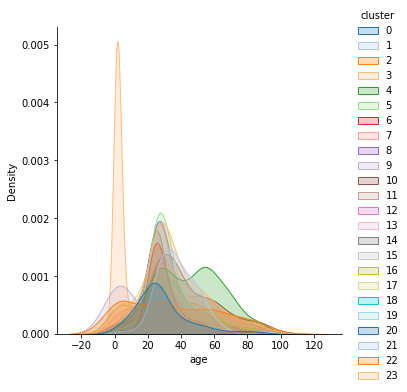

In [29]:
sns.displot(df, x ="age",hue="cluster",kind="kde", fill=True,palette=sns.color_palette("tab20",24))

## Gender distribution

C:\Users\lukas\AppData\Local\Temp\ipykernel_3656\2154252726.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["","Men","Women"])


Text(0.5, 1.0, 'Within cluster gender distribution')

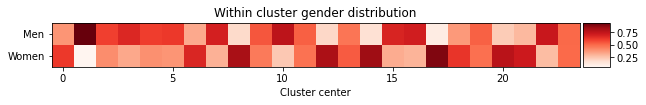

In [85]:
m = metrics.cluster.contingency_matrix(y[:,1], labels)

fig, ax = plt.subplots(figsize=(10,15))
im = ax.imshow(m/m.sum(axis=0,keepdims=True),cmap="Reds")

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax)

ax.set_xlabel("Cluster center")
ax.set_yticklabels(["","Men","Women"])
ax.set_title("Within cluster gender distribution")


In [56]:
pct = m/m.sum(axis=0,keepdims=True)

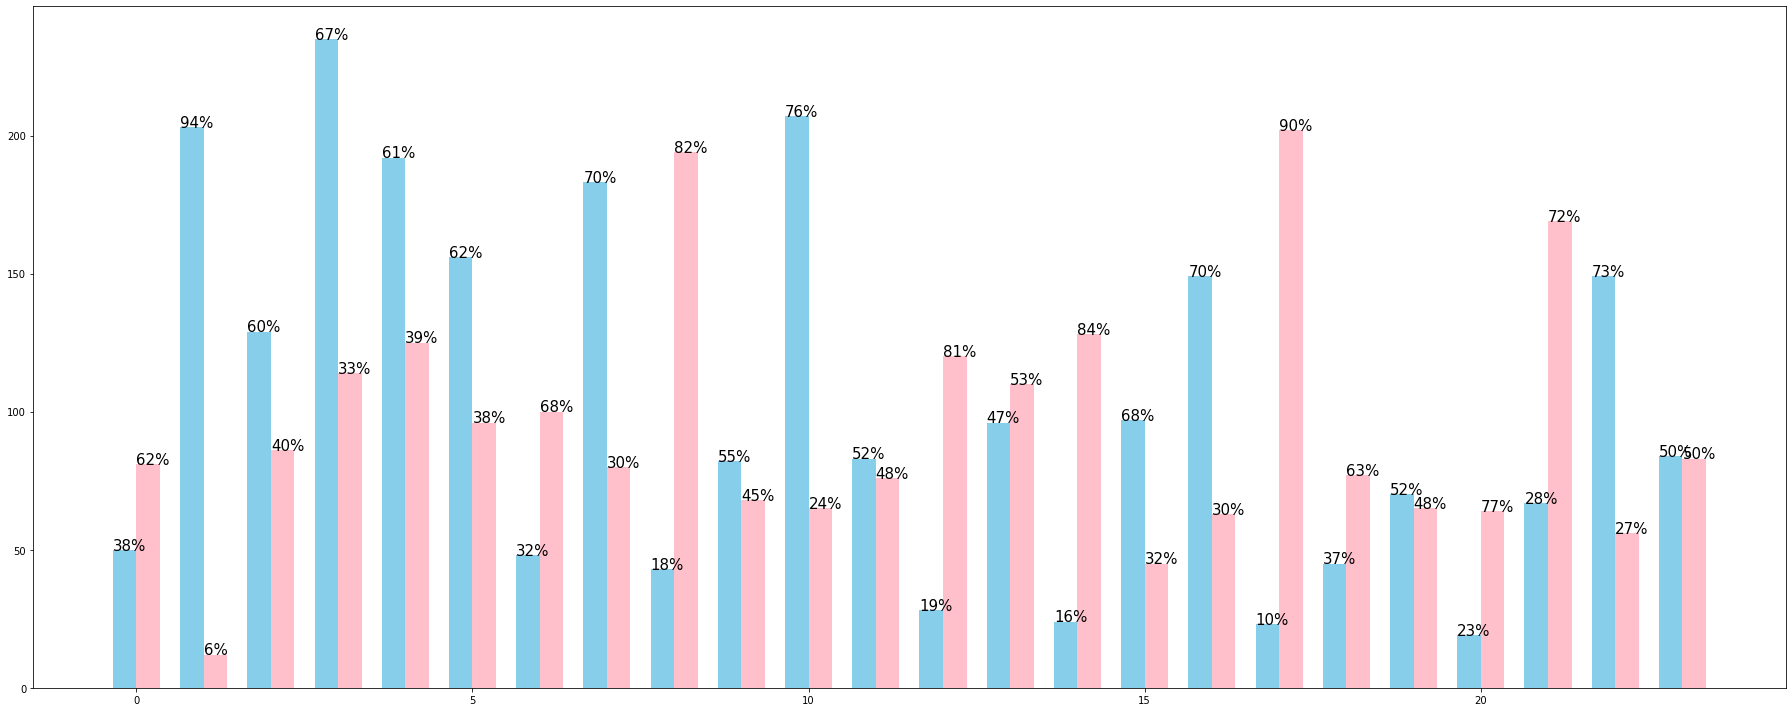

In [76]:
l_men, counts_men = np.unique(df[df["gender"] == 0]["cluster"], return_counts = True)
l_women, counts_women = np.unique(df[df["gender"] == 1]["cluster"], return_counts = True)

fig, ax = plt.subplots(figsize = (25,10))

# ax.set_xticks([i*5 for i in range(24)])
width = .35
ax.bar(l_men-width/2, counts_men, width = width, color = "skyblue")
ax.bar(l_women+width/2, counts_women, width = width, color = "pink")
for i in range(24):
    ax.text(l_men[i]-width, counts_men[i], s =str(int((pct[0][i]*100).round())) + "%", fontdict={"fontsize" : 15})
    ax.text(l_women[i], counts_women[i], s =str(int((pct[1][i]*100).round())) + "%", fontdict={"fontsize" : 15})

ax.set_fc()
fig.tight_layout()

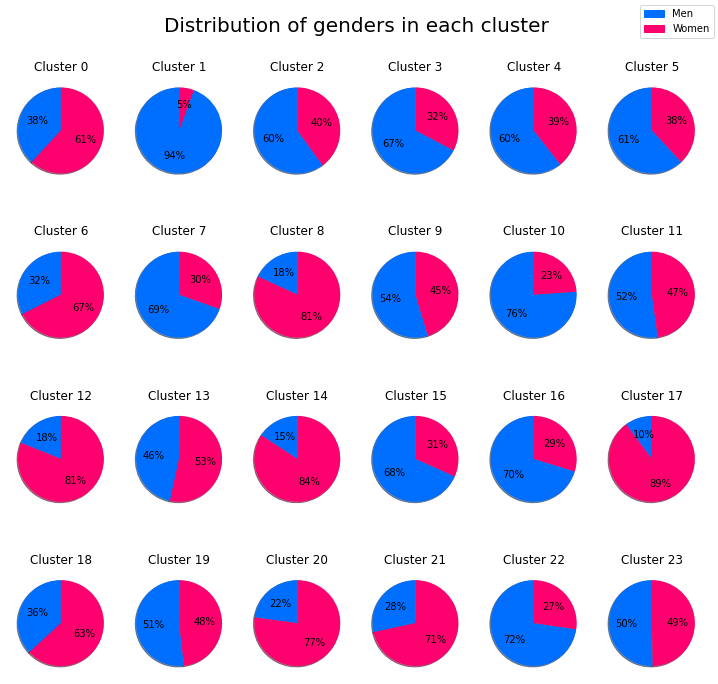

In [115]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(4, 6, figsize = (10,10))
fig.suptitle("Distribution of genders in each cluster", fontsize = 20)

# ax.scatter(range(24), pct[0])
for i in range(24):
    ax = axs[i//6, i%6]
    ax.pie(pct[:,i], autopct='%.d%%', shadow=True, startangle=90, colors=["#006FFF", "#FF006F"])#, labels=["Men", "women"])
    ax.set_title("Cluster " + str(i))

fig.legend(handles = [
    mpatches.Patch(color='#006FFF', label='Men'),
    mpatches.Patch(color='#FF006F', label='Women')
])
fig.tight_layout()

plt.savefig("../illustrations/cluster_pie.pdf")

## Race distribution